<a href="https://colab.research.google.com/github/olstjr/Brain-Tumor-Classification/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm
!pip install kaggle

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/T

In [ ]:
data_dir = 'brain-tumor-mri-dataset'
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def load_data(data_dir):
    images = []
    labels = []
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, 'Training', class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert('RGB')
            images.append(img)
            labels.append(class_idx)
    return images, labels

images, labels = load_data(data_dir)

# 데이터 분할
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = BrainTumorDataset(train_images, train_labels, transform=transform)
val_dataset = BrainTumorDataset(val_images, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class ViTForBrainTumor(nn.Module):
    def __init__(self, num_classes=4):
        super(ViTForBrainTumor, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTForBrainTumor().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
# 1
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_brain_tumor_model.pth')
        print('Best model saved!')

    print()

Epoch 1/10:
Train Loss: 0.4210, Train Acc: 0.8365
Val Loss: 0.1149, Val Acc: 0.9589
Best model saved!

Epoch 2/10:
Train Loss: 0.0948, Train Acc: 0.9691
Val Loss: 0.2414, Val Acc: 0.9178

Epoch 3/10:
Train Loss: 0.0703, Train Acc: 0.9755
Val Loss: 0.0966, Val Acc: 0.9650
Best model saved!

Epoch 4/10:
Train Loss: 0.0497, Train Acc: 0.9821
Val Loss: 0.2532, Val Acc: 0.9344

Epoch 5/10:
Train Loss: 0.0478, Train Acc: 0.9847
Val Loss: 0.0840, Val Acc: 0.9746
Best model saved!

Epoch 6/10:
Train Loss: 0.0225, Train Acc: 0.9928
Val Loss: 0.1719, Val Acc: 0.9624

Epoch 7/10:
Train Loss: 0.0246, Train Acc: 0.9921
Val Loss: 0.1307, Val Acc: 0.9571

Epoch 8/10:
Train Loss: 0.0424, Train Acc: 0.9849
Val Loss: 0.1847, Val Acc: 0.9396

Epoch 9/10:
Train Loss: 0.0298, Train Acc: 0.9908
Val Loss: 0.1387, Val Acc: 0.9589

Epoch 10/10:
Train Loss: 0.0140, Train Acc: 0.9950
Val Loss: 0.1628, Val Acc: 0.9571



Epoch 1/10:
Train Loss: 0.3955, Train Acc: 0.8496
Val Loss: 0.2842, Val Acc: 0.8941
Best model saved!

Epoch 2/10:
Train Loss: 0.1301, Train Acc: 0.9521
Val Loss: 0.1154, Val Acc: 0.9571
Best model saved!

Epoch 3/10:
Train Loss: 0.0720, Train Acc: 0.9744
Val Loss: 0.1449, Val Acc: 0.9554

Epoch 4/10:
Train Loss: 0.0518, Train Acc: 0.9818
Val Loss: 0.1331, Val Acc: 0.9641
Best model saved!

Epoch 5/10:
Train Loss: 0.0448, Train Acc: 0.9847
Val Loss: 0.1312, Val Acc: 0.9580

Epoch 6/10:
Train Loss: 0.0390, Train Acc: 0.9875
Val Loss: 0.1702, Val Acc: 0.9458

Epoch 7/10:
Train Loss: 0.0479, Train Acc: 0.9825
Val Loss: 0.1062, Val Acc: 0.9615

Epoch 8/10:
Train Loss: 0.0228, Train Acc: 0.9919
Val Loss: 0.1468, Val Acc: 0.9580

Epoch 9/10:
Train Loss: 0.0222, Train Acc: 0.9912
Val Loss: 0.4506, Val Acc: 0.8994

Epoch 10/10:
Train Loss: 0.0325, Train Acc: 0.9893
Val Loss: 0.1946, Val Acc: 0.9528



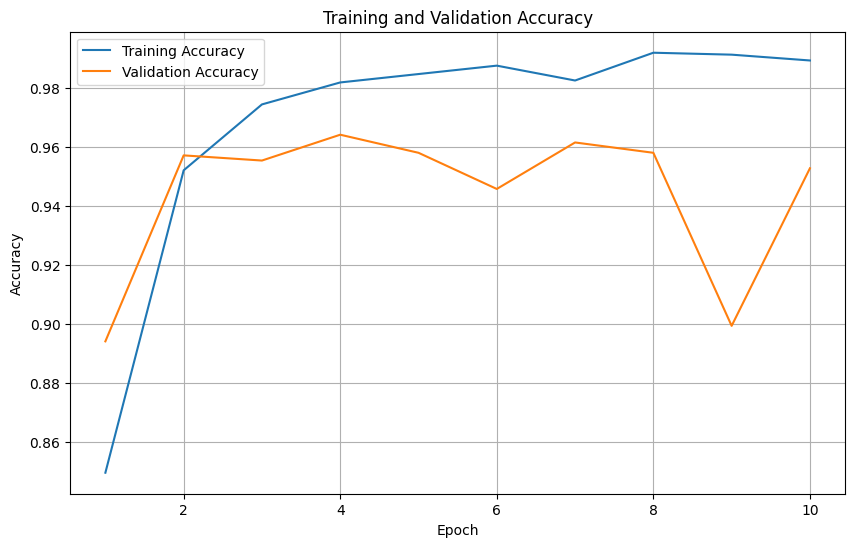

In [ ]:
# 2 정확도
num_epochs = 10
best_val_acc = 0.0

train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_brain_tumor_model2.pth')
        print('Best model saved!')

    print()

# 학습 후 정확도 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-15-6ee930577c20>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_brain_tumor_model.pth'))


Test Accuracy: 0.9779


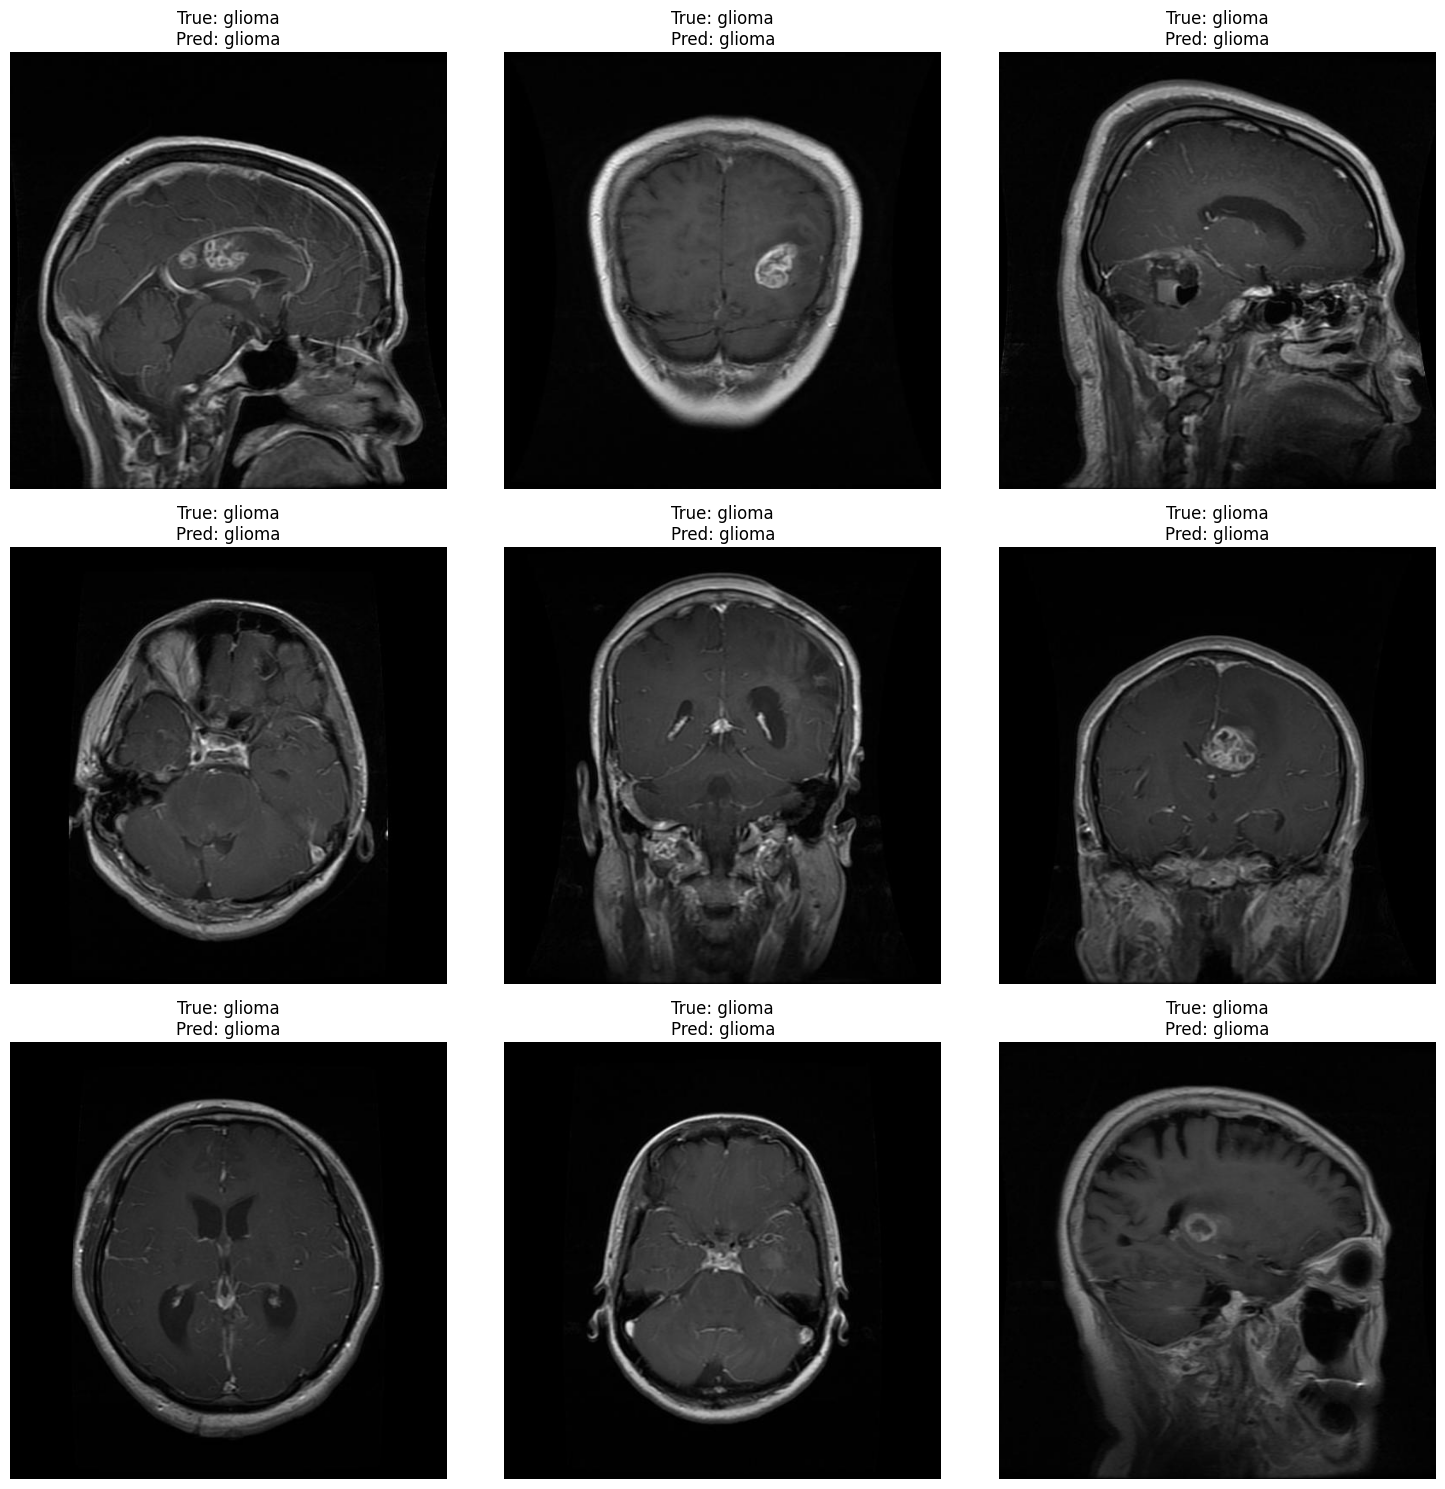

In [ ]:
def load_data(data_dir):
    images = []
    labels = []
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert('RGB')
            images.append(img)
            labels.append(class_idx)
    return images, labels

test_images, test_labels = load_data(os.path.join(data_dir, 'Testing'))
test_dataset = BrainTumorDataset(test_images, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_acc:.4f}')

# 테스트 이미지와 예측 결과 시각화
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    if i < len(test_images):
        ax.imshow(test_images[i])
        ax.set_title(f'True: {classes[all_labels[i]]}\nPred: {classes[all_preds[i]]}')
        ax.axis('off')
plt.tight_layout()
plt.show()